In [1]:
using Eirene
using MAT
using LinearAlgebra
using Statistics
using Printf
using PyPlot
using Distributions
using Random

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-6941429845270216589\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13172843794654127292\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-6941429845270216589\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## WSBM Generator

### Weighted Version Block Model (simple blocks without intersections)

In [92]:
function generate_clusters(n=100,pi_vector=[0.3,0.4,0.3])
    clusters_splits=round.(Int,cumsum(n*pi_vector))
    k = size(pi_vector)[1]
    c = zeros(Int8,n) 
    for k_ind in collect(1:k-1)
        c[clusters_splits[k_ind]+1:clusters_splits[k_ind+1]].=k_ind
    end
    return c
end

function generate_wsbm_adj(n,pi_vector,theta_in,theta_out,n_block=nothing,enh_param=nothing)
     c=generate_clusters(n,pi_vector)
     Adj=zeros(Float64,n,n)
     for i in collect(1:n-1)
        for j in collect(i+1:n)
            if c[i]==c[j]
                if n_block==nothing
                    Adj[i,j]=rand(LogitNormal(rand(Normal(theta_in),1)[1]))
                    Adj[j,i]=Adj[i,j]
                else
                    if c[i]==n_block-1
                        Adj[i,j]=rand(LogitNormal(rand(Normal(theta_in),1)[1]))*enh_param
                        Adj[j,i]=Adj[i,j]
                    else
                        Adj[i,j]=rand(LogitNormal(rand(Normal(theta_in),1)[1]))
                        Adj[j,i]=Adj[i,j]
                    end
                end
            else
                 Adj[i,j]=rand(LogitNormal(rand(Normal(theta_out),1)[1]))
                 Adj[j,i]=Adj[i,j]
            end
        end
    end
    Adj[diagind(Adj)].= 1
    return Adj
end

function generate_wsbm_adj_h(n,pi_vector,theta_in,theta_out,n_block=nothing)
     c=generate_clusters(n,pi_vector)
     Adj=zeros(Float64,n,n)
     for i in collect(1:n-1)
        for j in collect(i+1:n)
            if c[i]==c[j]
                if n_block==nothing
                    Adj[i,j]=rand(LogitNormal(rand(Normal(theta_in),1)[1]))
                    Adj[j,i]=Adj[i,j]
                end
        
            else
                 Adj[i,j]=rand(LogitNormal(rand(Normal(theta_out),1)[1]))
                 Adj[j,i]=Adj[i,j]
            end
        end
    end
    Adj[diagind(Adj)].= 1
    return Adj
end                    

generate_wsbm_adj_h (generic function with 2 methods)

### TDA part

In [93]:
function get_distance(matrix)
   
    distC = ((matrix.-1).*(-1)).^0.5;
    distC[diagind(distC)].= 0; 
    return distC
end 
function TDA(matrix)
    dist_mat=get_distance(matrix)
    C=eirene(dist_mat,maxdim=1)
    return C
end
function write_barcode_to_file(C, filename; maxdim = 2)

    open(filename,"w") do f
        
        for dim in collect(0:maxdim)
        
            b = barcode(C, dim = dim)
            num = size(b)[1]
        
            write(f,string("Dimension: ", dim,"\n"))
            #println(string("Dimension: ", dim,"\n"))
                  
            
            for j in collect(1:num)
    
                ints = @sprintf "[%.3f, %.3f): " b[j,1] b[j,2]
                repr = classrep(C, class = j, dim = dim)
                part1 = @sprintf "[%.3f, %.3f): " b[j,1] b[j,2]
            
                simplList = []
                for i in collect(1:size(repr)[2]) 
                    push!(simplList,"["*join(string.(repr[:,i]),",")*"]")
                end 
            
                part2 = string(part1, join(simplList,"+"),"\n")
                write(f,part2)
            end
        end
        
    end
end

write_barcode_to_file (generic function with 1 method)

## Models

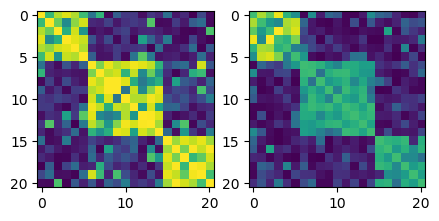

PyObject <matplotlib.image.AxesImage object at 0x16fe8f890>

In [94]:
number_of_nodes = 21
pi_vector = [0.3,0.4,0.3]
theta_in = 2
theta_out = -2
wAdj = generate_wsbm_adj(number_of_nodes,pi_vector,theta_in,theta_out)
wAdj_enh = generate_wsbm_adj(21,[0.3,0.4,0.3],2,-2,1,1.5)
plt.figure(figsize=(5,5))
subplot(121); imshow(wAdj)
subplot(122); imshow(wAdj_enh)

In [95]:
fname = string("wAdj_", join(pi_vector,'_'),"_",theta_in,"_",abs(theta_out),".mat")
file = matopen(fname, "w")
write(file, "wAdj", wAdj)
close(file)

## TDA part

In [96]:
C=TDA(wAdj);
filename = string("ints_",number_of_nodes,'_',join(pi_vector,'_'),'_',theta_in,'_', abs(theta_out), ".txt")
write_barcode_to_file(C, filename, maxdim = 1)